# GLM regression models using sociodemographic variables (X) and mortality (y) at different moments of the COVID-19 pandemic.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import skew, kurtosis
import numpy as np
from scipy.stats import poisson
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess
import pickle

from util import tunning_negative_binomial_model, save_model, \
    summarize_results, outlier_analysis

## Loading data

In [18]:
df_variables = pd.read_csv('data/output/df_without_collinearity_standardized.csv', index_col=0)

In [19]:
df_y = pd.read_csv('data/output/df_mortality.csv', index_col=0)

In [20]:
df_municipalities = pd.read_csv('data/output/df_base_without_missing_points.csv', index_col=0)

In [21]:
df_cluster_labels = pd.read_csv('data/output/df_labeled_cluster.csv', index_col=0)[['cluster_label']].copy()
custom_order = pd.CategoricalDtype(
    categories=[
        'Urbanized',
        'Urbanized with informal settlements',        
        'Semi-urbanized',
        'Rural with high human development',
        'Rural with low human development'
    ],
    ordered=True
)
df_cluster_labels['cluster_label'] = df_cluster_labels['cluster_label'].astype(custom_order)
df_cluster_labels = df_cluster_labels.sort_values('cluster_label') 

In [22]:
df_cluster_probabilities = pd.read_csv('data/output/df_standardized_pca_all_spherical_5_probability.csv', index_col=0)
df_cluster_probabilities.columns = ['Semi-urbanized', 'Rural with high human development', 'Urbanized with informal settlements', 'Rural with low human development', 'Urbanized']

## Analyzing mortality rate distribution

Death rate (1/2020) : mean =  14.8 var =  549.56 dispersion =  37.14


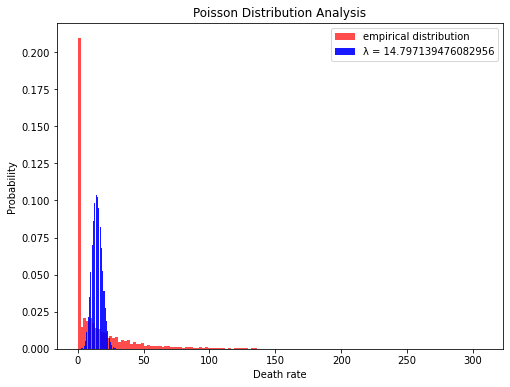

Death rate (2020) : mean =  66.16 var =  2206.48 dispersion =  33.35


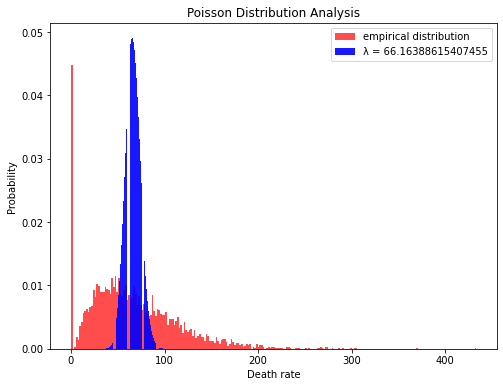

Death rate (2021) : mean =  178.35 var =  10110.95 dispersion =  56.69


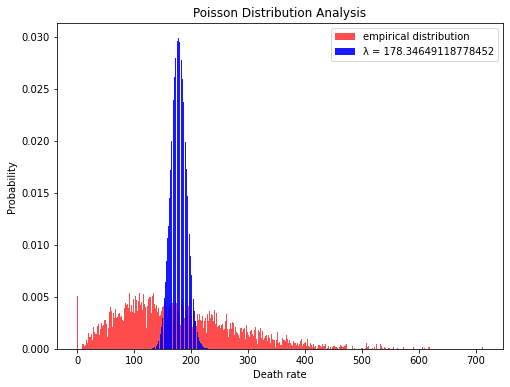

Death rate (2022) : mean =  31.61 var =  746.33 dispersion =  23.61


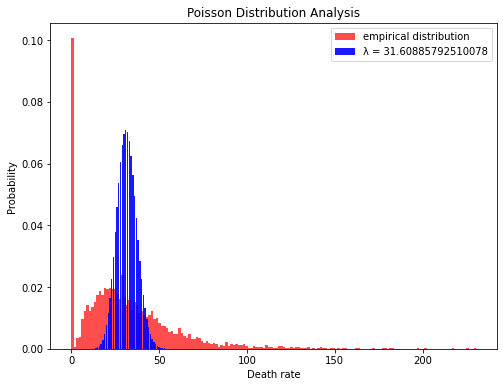

Death rate (accumulated period) : mean =  276.12 var =  16772.61 dispersion =  60.74


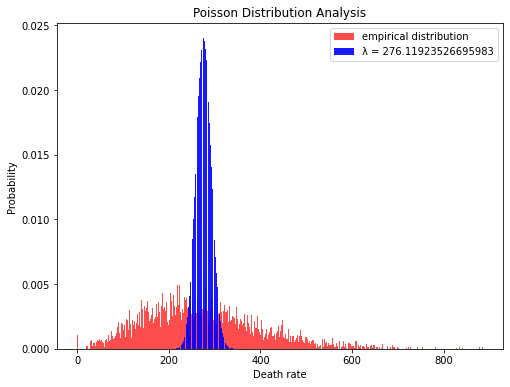

In [23]:
for column in ['Death rate (1/2020)', 'Death rate (2020)', 'Death rate (2021)', 'Death rate (2022)', 'Death rate (accumulated period)']:
    y = df_y[column].values
    y_mean = y.mean()    
    y_var = y.var()
    y_dispersion = y_var/y_mean
    print(column,':', 'mean = ', round(y_mean,2), 'var = ', round(y_var,2), 'dispersion = ', round(y_dispersion,2))
    
    y_bootstrap = np.random.choice(y, size=100000)
    
    x_values = np.arange(0, int(y_bootstrap.max()))
    pmf_values = poisson.pmf(x_values, mu=y_mean)
    
    # Plot the Poisson distribution
    plt.figure(figsize=(8, 6))
    plt.hist(y_bootstrap, bins=int(len(set(y_bootstrap.astype(int)))/1), density=True, color='red', alpha=0.7, label='empirical distribution')
    plt.bar(x_values, pmf_values, color='blue', alpha=0.9, label=f'λ = {y_mean}')
    plt.title('Poisson Distribution Analysis')
    plt.xlabel('Death rate')
    plt.ylabel('Probability')   
    plt.legend()
    plt.show()

In [24]:
df_y.columns

Index(['code_municipality_6', 'code_municipality_7', 'population', 'date',
       'deaths', 'new_deaths', 'deaths_accumulated_first_semester_2020',
       'delta_first_death_2020-06-30', 'deaths_accumulated_2020',
       'delta_first_death_2020-12-31', 'deaths_accumulated_2021',
       'delta_first_death_2021-12-31', 'delta_first_death_2022-12-31',
       'delta_first_death_general_period',
       'death_rate_accumulated_first_semester_2020',
       'death_rate_accumulated_2020', 'death_rate_accumulated_2021',
       'Death rate (accumulated period)', 'Death rate (2022)',
       'Death rate (2021)', 'Death rate (2020)', 'Death rate (1/2020)',
       'deaths_2022', 'deaths_2021', 'death_accumulated_2020_04',
       'death_accumulated_2020_04_rate', 'death_accumulated_2020_06',
       'death_accumulated_2020_06_rate', 'death_accumulated_2020_08',
       'death_accumulated_2020_08_rate', 'death_accumulated_2020_10',
       'death_accumulated_2020_10_rate', 'death_accumulated_2020_12',
   

In [25]:
for column in ['deaths_accumulated_first_semester_2020', 'deaths_accumulated_2020']:
    print('\nColumn:', column)
    print(df_y[column].describe().round(2))


Column: deaths_accumulated_first_semester_2020
count    5560.00
mean       13.98
std       179.25
min         0.00
25%         0.00
50%         1.00
75%         3.00
max      8835.00
Name: deaths_accumulated_first_semester_2020, dtype: float64

Column: deaths_accumulated_2020
count     5560.00
mean        38.21
std        336.20
min          0.00
25%          2.00
50%          6.00
75%         17.00
max      16585.00
Name: deaths_accumulated_2020, dtype: float64


## Statistical analysis
Model 0: clusters without any control.<br/>
Model 1: clusters controlled by sociodemographic variables.<br/>
Model 2: clusters controlled by sociodemographic variables and delta days since the first death in the period.<br/>
Model 3: cluster probabilities controlled by the delta days since the first death in the period.<br/>
Model 4: cluster probabilities controlled by sociodemographic variables.<br/>
Model 5: cluster probabilities controlled by sociodemographic variables and delta days since the first death in the period.<br/>
Model 6: cluster probabilities without control.<br/>

In [26]:
list_population =  df_y['population']
list_offset = np.log(list_population)

In [27]:
def check_residuals_normality(residuals, residual_label):
    print('\n***Residuals: ',residual_label)
    
    statistic, p_value = shapiro(residuals)
    print("Shapiro-Wilk Test Statistic:", statistic)
    print("p-value:", p_value)    
    if p_value > 0.05:
        print("Sample looks Gaussian (fail to reject H0)")
    else:
        print("Sample does not look Gaussian (reject H0)")
    # Compute skewness
    skewness = skew(residuals)    
    # Compute kurtosis
    kurt = kurtosis(residuals)    
    # Print the results
    print("Skewness:", skewness)
    print("Kurtosis:", kurt) 
    
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Normal Q-Q plot')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel(residual_label)
    plt.grid(True)
    plt.show()    

In [28]:
def plot_results_basic(model, y, x):        
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, y, color='blue', label='Predicted vs Actual', edgecolors='blue', facecolors='none')
    plt.plot(y, y, color='red', label='Perfect Fit')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Predicted vs Actual Values')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    population = df_y.loc[y.index]['population']
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues/population*100000, y/population*100000, color='blue', label='Predicted vs Actual (Death rates)', edgecolors='blue', facecolors='none')
    plt.plot(y/population*100000, y/population*100000, color='red', label='Perfect Fit')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Predicted vs Actual (Death rates)')
    plt.legend()
    plt.grid(True)
    plt.show()    
    

    resid_pearson = model.resid_pearson    
    standardized_pearson_residuals = resid_pearson / np.sqrt(model.fittedvalues)    
    
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, resid_pearson, color='blue', label='Predicted vs Pearson Residuals', edgecolors='blue', facecolors='none')
    lowess_smooth = lowess(resid_pearson, model.fittedvalues, frac=0.2)
    plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', label='LOWESS Smooth Curve')
    plt.xlabel('Predicted Values')
    plt.ylabel('resid_pearson')
    plt.title('Predicted vs Residuals')
    plt.legend()
    plt.grid(True)
    plt.show()    
    
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, standardized_pearson_residuals, color='blue', label='Predicted vs Pearson Residuals', edgecolors='blue', facecolors='none')
    lowess_smooth = lowess(standardized_pearson_residuals, model.fittedvalues, frac=0.2)
    plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', label='LOWESS Smooth Curve')
    plt.xlabel('Predicted Values')
    plt.ylabel('standardized_pearson_residuals')
    plt.title('Predicted vs Residuals')
    plt.legend()
    plt.grid(True)
    plt.show()    

    check_residuals_normality(resid_pearson, 'resid_pearson')
    check_residuals_normality(standardized_pearson_residuals, 'standardized_pearson_residuals')

In [29]:
def plot_results(model, y, x):        
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, y, color='blue', label='Predicted vs Actual', edgecolors='blue', facecolors='none')
    plt.plot(y, y, color='red', label='Perfect Fit')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Predicted vs Actual Values')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    population = df_y.loc[y.index]['population']
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues/population*100000, y/population*100000, color='blue', label='Predicted vs Actual (Death rates)', edgecolors='blue', facecolors='none')
    plt.plot(y/population*100000, y/population*100000, color='red', label='Perfect Fit')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Predicted vs Actual (Death rates)')
    plt.legend()
    plt.grid(True)
    plt.show()    
    
    resid_response = model.resid_response
    resid_pearson = model.resid_pearson
    quantile_residuals = resid_response / np.sqrt(model.fittedvalues)
    
    standardized_pearson_residuals = resid_pearson / np.sqrt(model.fittedvalues)
    standardized_quantile_residuals = quantile_residuals / quantile_residuals.std()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, resid_pearson, color='blue', label='Predicted vs Pearson Residuals', edgecolors='blue', facecolors='none')
    lowess_smooth = lowess(resid_pearson, model.fittedvalues, frac=0.2)
    plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', label='LOWESS Smooth Curve')
    plt.xlabel('Predicted Values')
    plt.ylabel('resid_pearson')
    plt.title('Predicted vs Residuals')
    plt.legend()
    plt.grid(True)
    plt.show()    
    
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, standardized_pearson_residuals, color='blue', label='Predicted vs Pearson Residuals', edgecolors='blue', facecolors='none')
    lowess_smooth = lowess(standardized_pearson_residuals, model.fittedvalues, frac=0.2)
    plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', label='LOWESS Smooth Curve')
    plt.xlabel('Predicted Values')
    plt.ylabel('standardized_pearson_residuals')
    plt.title('Predicted vs Residuals')
    plt.legend()
    plt.grid(True)
    plt.show()    
    
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, standardized_quantile_residuals, color='blue', label='Predicted vs Pearson Residuals', edgecolors='blue', facecolors='none')
    lowess_smooth = lowess(standardized_quantile_residuals, model.fittedvalues, frac=0.2)
    plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', label='LOWESS Smooth Curve')
    plt.xlabel('Predicted Values')
    plt.ylabel('standardized_quantile_residuals')
    plt.title('Predicted vs Residuals')
    plt.legend()
    plt.grid(True)
    plt.show()    
    
    check_residuals_normality(resid_response, 'resid_response')
    check_residuals_normality(resid_pearson, 'resid_pearson')
    check_residuals_normality(standardized_pearson_residuals, 'standardized_pearson_residuals')
    check_residuals_normality(quantile_residuals, 'quantile_residuals')
    check_residuals_normality(standardized_quantile_residuals, 'standardized_quantile_residuals')

    df_municipalities_temp = df_municipalities.loc[y.index]

    plt.figure(figsize=(10, 6))
    plt.scatter(df_municipalities_temp['longitude'], quantile_residuals, color='blue', label='Longitude vs residuals', edgecolors='blue', facecolors='none')
    lowess_smooth = lowess(quantile_residuals, df_municipalities_temp['longitude'], frac=0.2)
    plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', label='LOWESS Smooth Curve')
    plt.xlabel('Longitude')
    plt.ylabel('Residuals')
    plt.title('Longitude vs Residuals')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(df_municipalities_temp['latitude'], quantile_residuals, color='blue', label='Latitude vs residuals', edgecolors='blue', facecolors='none')
    lowess_smooth = lowess(quantile_residuals, df_municipalities_temp['latitude'], frac=0.2)
    plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', label='LOWESS Smooth Curve')
    plt.xlabel('Latitude')
    plt.ylabel('Residuals')
    plt.title('Latitude vs Residuals')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    for i in range(len(x.columns[1:])):
        plt.figure(figsize=(10, 6))
        plt.scatter(x[x.columns[1:][i]], quantile_residuals, color='blue', edgecolors='blue', facecolors='none')
        lowess_smooth = lowess(quantile_residuals, x[x.columns[1:][i]], frac=0.2)
        plt.plot(lowess_smooth[:, 0], lowess_smooth[:, 1], color='red', label='LOWESS Smooth Curve')
        plt.xlabel(x.columns[1:][i])
        plt.ylabel('Quantile Residuals')        
        plt.grid(True)
        plt.show()    

In [30]:
def collinearity_analysis(df_x):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df_x.columns
    vif_data['VIF'] = [variance_inflation_factor(df_x.values, i) for i in range(df_x.shape[1])]
    return vif_data

In [31]:
def run_model(x, y, model_name, period):
    model_name_period = model_name + '_' + period
    print('\n===>',model_name_period)
    print(collinearity_analysis(x))
    x = sm.add_constant(x)
    model = tunning_negative_binomial_model(x, y, list_offset)
    save_model(model, model_name_period)
    summarize_results(model)
    plot_results_basic(model, y, x)
    outlier_analysis(model)
    return model    


*** Period:  2020_1
Death mean:  13.98 variance:  32131.92 dispersion:  2298.62

===> model_6_2020_1
                               Feature  VIF
0                       Semi-urbanized  inf
1    Rural with high human development  inf
2  Urbanized with informal settlements  inf
3     Rural with low human development  inf
4                            Urbanized  inf


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Selected alpha: 0.9600000000000001
                           Generalized Linear Model Regression Results                            
Dep. Variable:     deaths_accumulated_first_semester_2020   No. Observations:                 5560
Model:                                                GLM   Df Residuals:                     5555
Model Family:                            NegativeBinomial   Df Model:                            4
Link Function:                                        Log   Scale:                          1.0000
Method:                                              IRLS   Log-Likelihood:                -10411.
Date:                                    Wed, 19 Jun 2024   Deviance:                       5290.9
Time:                                            09:46:36   Pearson chi2:                 6.25e+03
No. Iterations:                                       100   Pseudo R-squ. (CS):             0.2367
Covariance Type:                                nonrobust                 

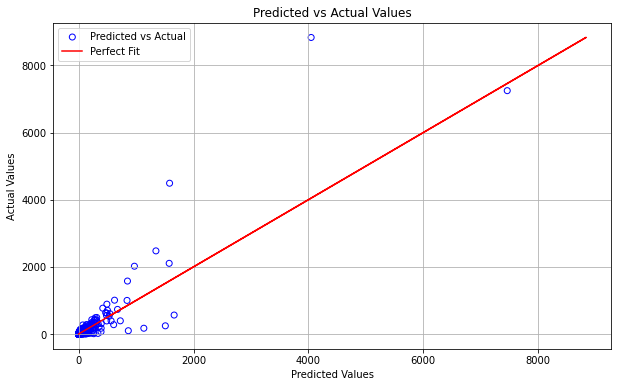

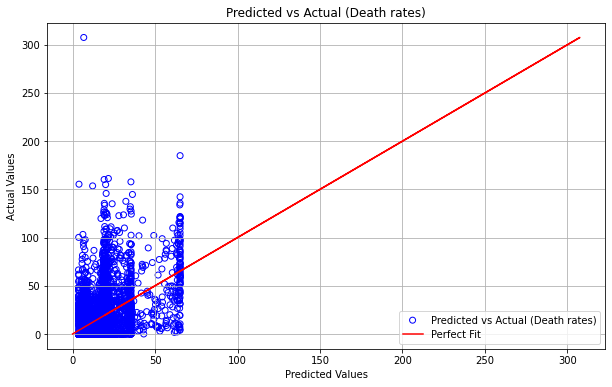

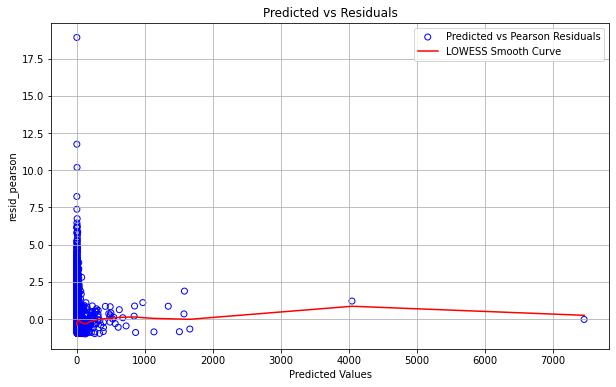

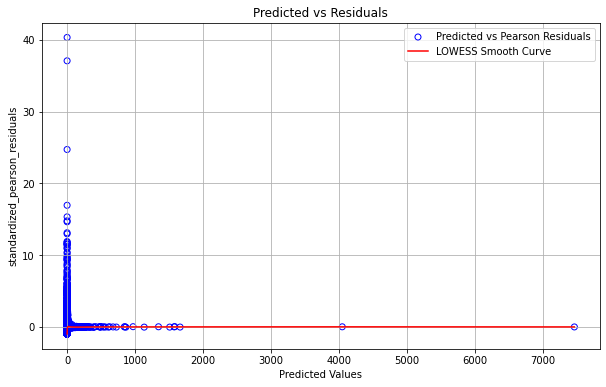


***Residuals:  resid_pearson
Shapiro-Wilk Test Statistic: 0.7104946970939636
p-value: 0.0
Sample does not look Gaussian (reject H0)
Skewness: 3.438317241784464
Kurtosis: 28.041119973270675


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


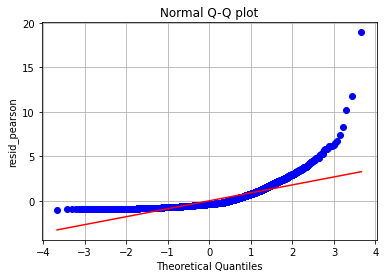


***Residuals:  standardized_pearson_residuals
Shapiro-Wilk Test Statistic: 0.4649655222892761
p-value: 0.0
Sample does not look Gaussian (reject H0)
Skewness: 9.512646646958107
Kurtosis: 173.99673912789711


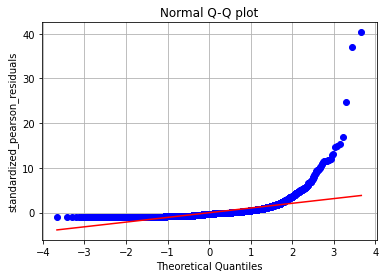

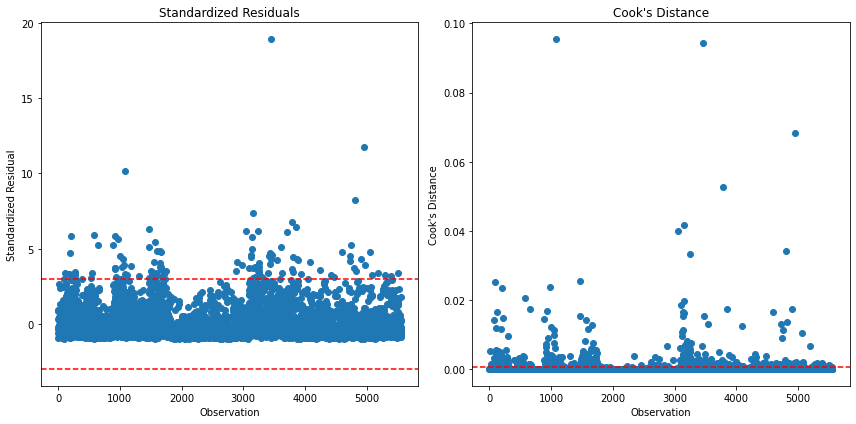

Quantity outliers (Standardized Residuals > 3): 118
Quantity influential Points (Cook's Distance > 4/n): 415

*** Period:  2020
Death mean:  38.21 variance:  113029.96 dispersion:  2958.2

===> model_6_2020
                               Feature  VIF
0                       Semi-urbanized  inf
1    Rural with high human development  inf
2  Urbanized with informal settlements  inf
3     Rural with low human development  inf
4                            Urbanized  inf


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Selected alpha: 0.25
                    Generalized Linear Model Regression Results                    
Dep. Variable:     deaths_accumulated_2020   No. Observations:                 5560
Model:                                 GLM   Df Residuals:                     5555
Model Family:             NegativeBinomial   Df Model:                            4
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -16690.
Date:                     Wed, 19 Jun 2024   Deviance:                       6158.4
Time:                             09:48:13   Pearson chi2:                 5.70e+03
No. Iterations:                        100   Pseudo R-squ. (CS):             0.1055
Covariance Type:                 nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

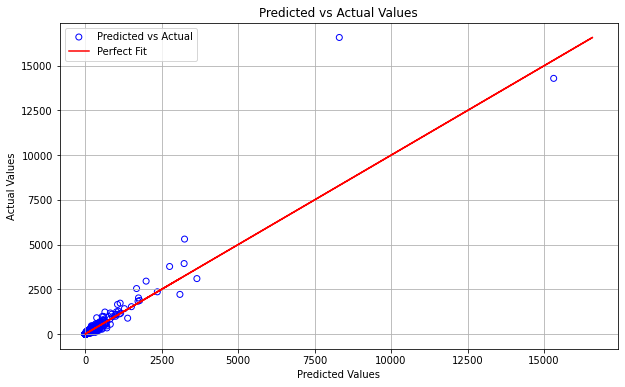

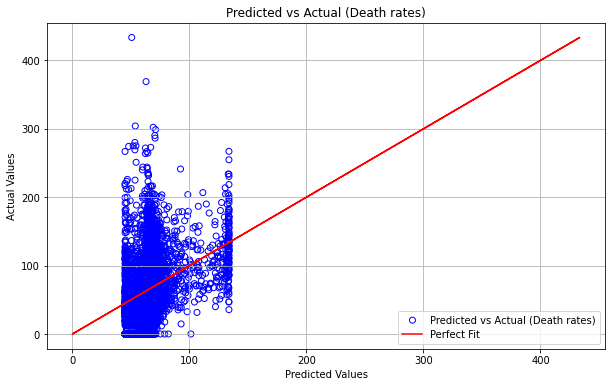

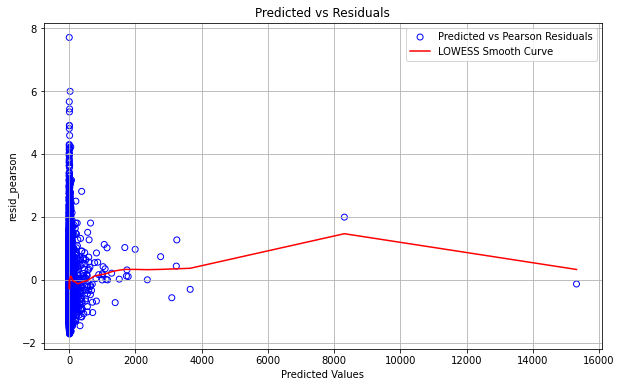

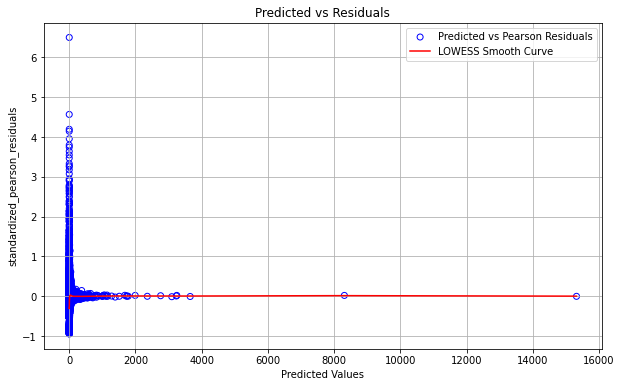


***Residuals:  resid_pearson
Shapiro-Wilk Test Statistic: 0.9330754280090332
p-value: 1.8216880036222622e-44
Sample does not look Gaussian (reject H0)
Skewness: 1.1323655243829394
Kurtosis: 2.150159807404342


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


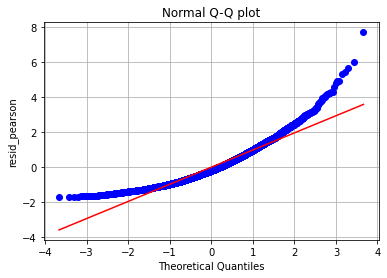


***Residuals:  standardized_pearson_residuals
Shapiro-Wilk Test Statistic: 0.8479329347610474
p-value: 0.0
Sample does not look Gaussian (reject H0)
Skewness: 2.334713299685145
Kurtosis: 13.847422875543682


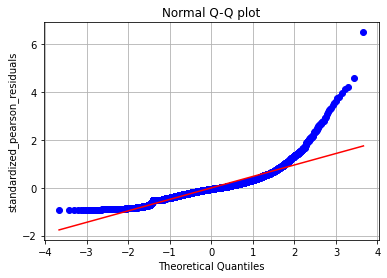

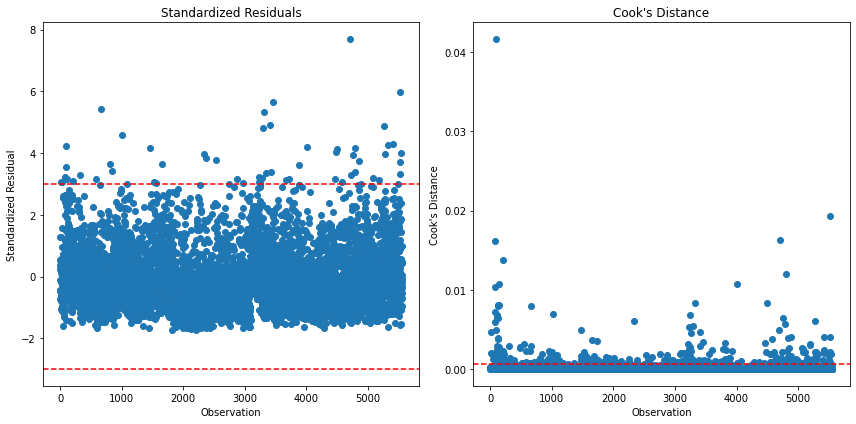

Quantity outliers (Standardized Residuals > 3): 59
Quantity influential Points (Cook's Distance > 4/n): 294

*** Period:  2021
Death mean:  76.25 variance:  227434.9 dispersion:  2982.56

===> model_6_2021
                               Feature  VIF
0                       Semi-urbanized  inf
1    Rural with high human development  inf
2  Urbanized with informal settlements  inf
3     Rural with low human development  inf
4                            Urbanized  inf


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Selected alpha: 0.12
                 Generalized Linear Model Regression Results                  
Dep. Variable:            deaths_2021   No. Observations:                 5560
Model:                            GLM   Df Residuals:                     5555
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20109.
Date:                Wed, 19 Jun 2024   Deviance:                       6064.0
Time:                        09:49:53   Pearson chi2:                 5.96e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5132
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

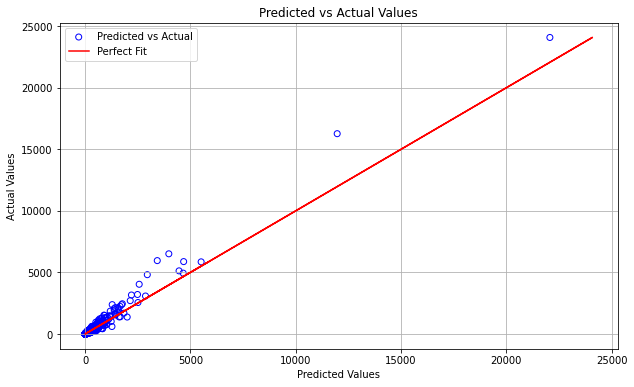

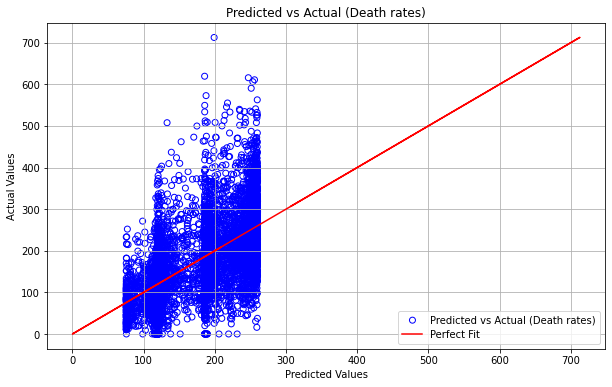

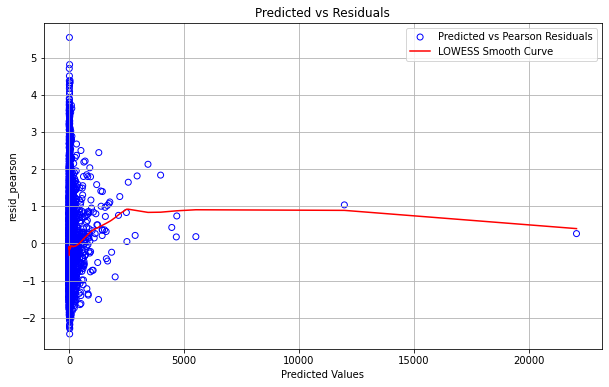

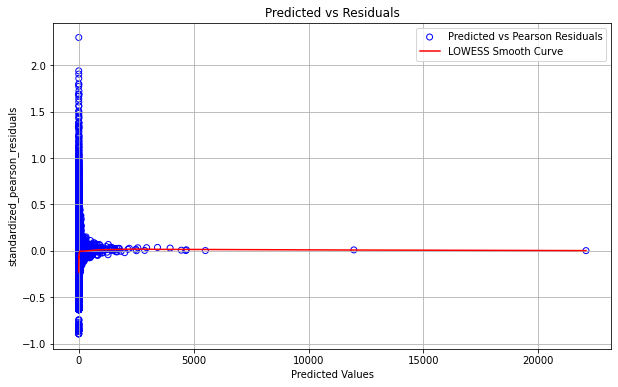


***Residuals:  resid_pearson
Shapiro-Wilk Test Statistic: 0.9614710807800293
p-value: 4.5370953795152416e-36
Sample does not look Gaussian (reject H0)
Skewness: 0.8555397553475736
Kurtosis: 1.1584938300171457


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


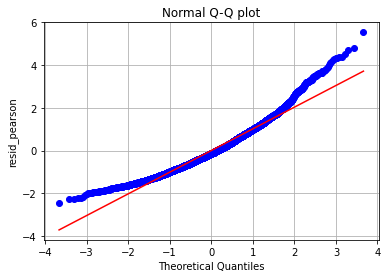


***Residuals:  standardized_pearson_residuals
Shapiro-Wilk Test Statistic: 0.9213771820068359
p-value: 0.0
Sample does not look Gaussian (reject H0)
Skewness: 1.2159027329358973
Kurtosis: 4.916933789143726


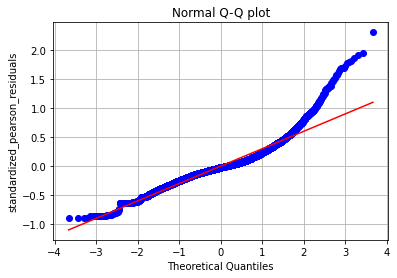

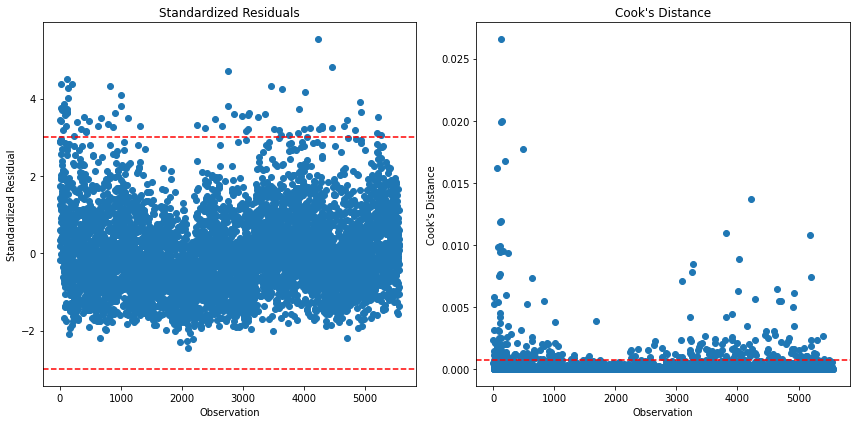

Quantity outliers (Standardized Residuals > 3): 72
Quantity influential Points (Cook's Distance > 4/n): 291

*** Period:  2022
Death mean:  11.75 variance:  4805.98 dispersion:  409.1

===> model_6_2022
                               Feature  VIF
0                       Semi-urbanized  inf
1    Rural with high human development  inf
2  Urbanized with informal settlements  inf
3     Rural with low human development  inf
4                            Urbanized  inf


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Selected alpha: 0.14
                 Generalized Linear Model Regression Results                  
Dep. Variable:            deaths_2022   No. Observations:                 5560
Model:                            GLM   Df Residuals:                     5555
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12638.
Date:                Wed, 19 Jun 2024   Deviance:                       6086.6
Time:                        09:50:59   Pearson chi2:                 5.73e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.2642
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

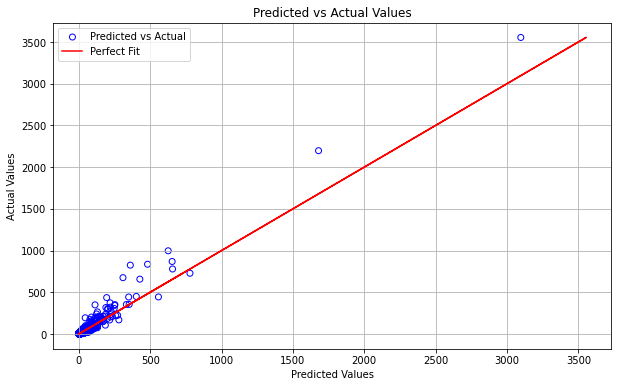

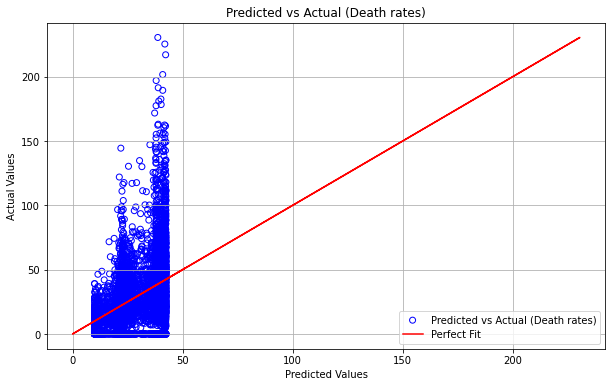

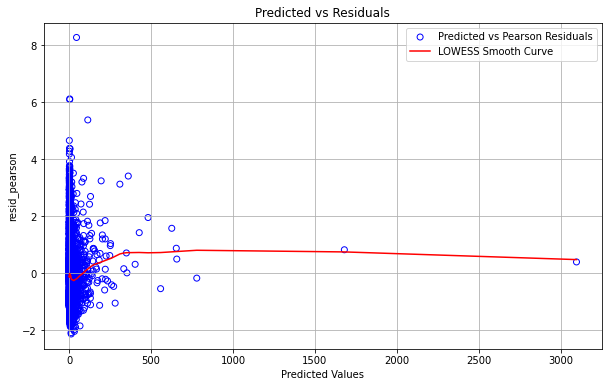

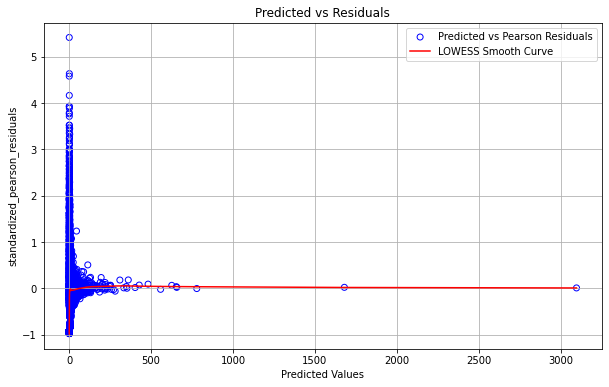


***Residuals:  resid_pearson
Shapiro-Wilk Test Statistic: 0.9444345235824585
p-value: 1.5742186948224995e-41
Sample does not look Gaussian (reject H0)
Skewness: 1.0294298238537727
Kurtosis: 1.9383527127667914


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


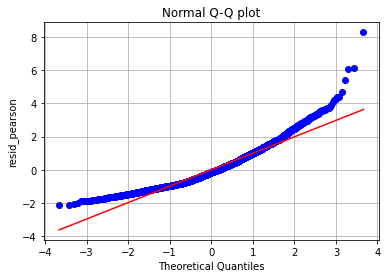


***Residuals:  standardized_pearson_residuals
Shapiro-Wilk Test Statistic: 0.8974511623382568
p-value: 0.0
Sample does not look Gaussian (reject H0)
Skewness: 1.4988125199183935
Kurtosis: 4.765590546998303


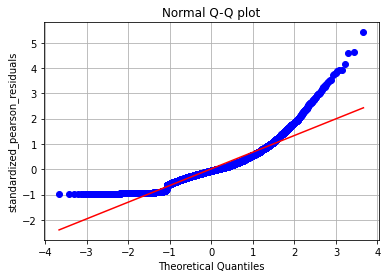

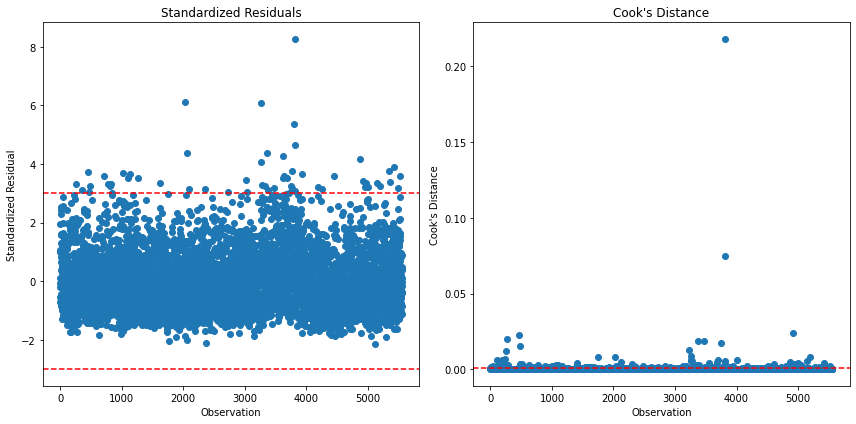

Quantity outliers (Standardized Residuals > 3): 57
Quantity influential Points (Cook's Distance > 4/n): 248

*** Period:  2020_2022
Death mean:  126.21 variance:  758887.04 dispersion:  6012.82

===> model_6_2020_2022
                               Feature  VIF
0                       Semi-urbanized  inf
1    Rural with high human development  inf
2  Urbanized with informal settlements  inf
3     Rural with low human development  inf
4                            Urbanized  inf


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Selected alpha: 0.09999999999999999
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                 5560
Model:                            GLM   Df Residuals:                     5555
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21898.
Date:                Wed, 19 Jun 2024   Deviance:                       5785.8
Time:                        09:52:06   Pearson chi2:                 5.65e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.4241
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

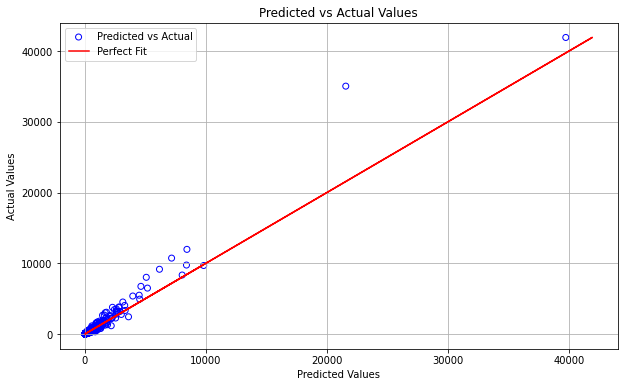

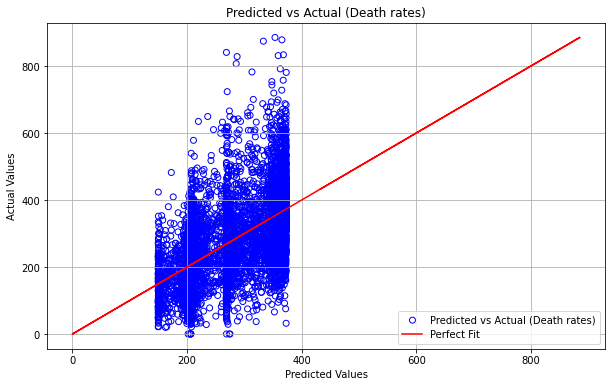

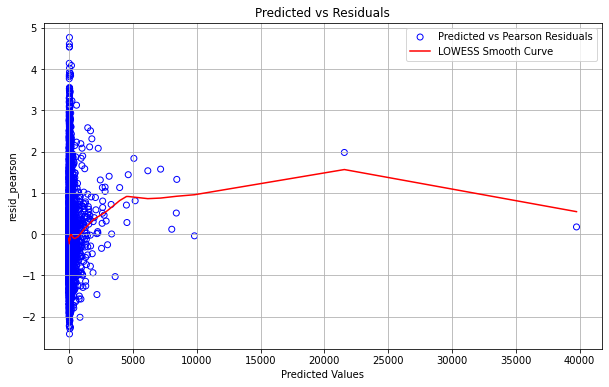

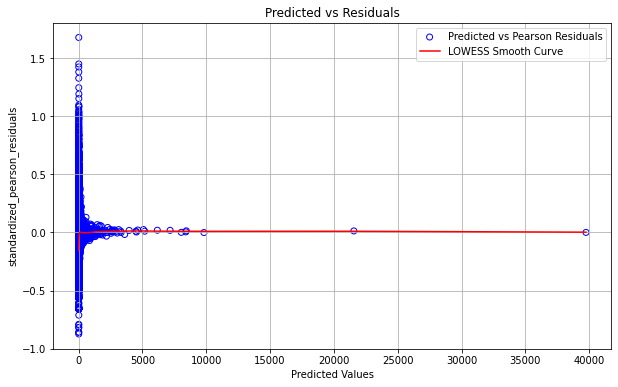


***Residuals:  resid_pearson
Shapiro-Wilk Test Statistic: 0.9751191139221191
p-value: 4.488945853473809e-30
Sample does not look Gaussian (reject H0)
Skewness: 0.6747172458999054
Kurtosis: 0.6765416612153747


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


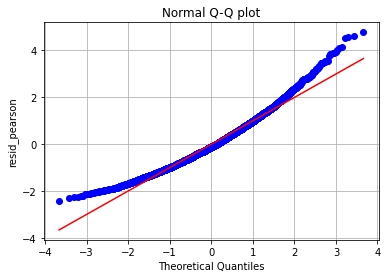


***Residuals:  standardized_pearson_residuals
Shapiro-Wilk Test Statistic: 0.9428614974021912
p-value: 5.811184731555016e-42
Sample does not look Gaussian (reject H0)
Skewness: 0.8818316639507852
Kurtosis: 3.6523035463895717


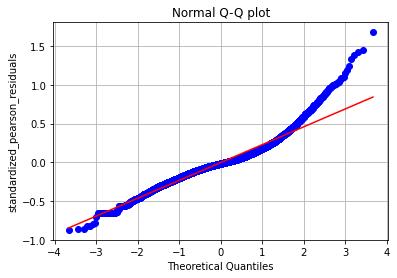

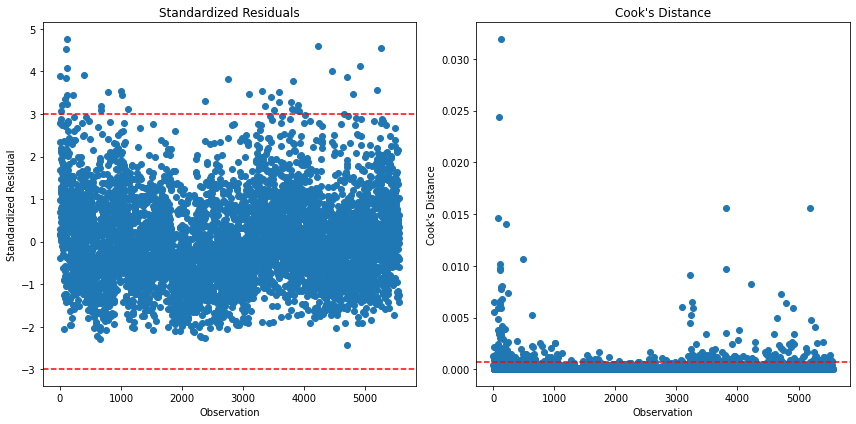

Quantity outliers (Standardized Residuals > 3): 41
Quantity influential Points (Cook's Distance > 4/n): 270


In [32]:
list_columns_y = ['deaths_accumulated_first_semester_2020', 'deaths_accumulated_2020', 'deaths_2021', 'deaths_2022', 'deaths']
list_periods = ['2020_1','2020', '2021', '2022', '2020_2022']
list_delta_first_death_columns = ['delta_first_death_2020-06-30', 'delta_first_death_2020-12-31', 'delta_first_death_2021-12-31', 'delta_first_death_2022-12-31', 'delta_first_death_general_period']

for i in range(5):
    column_y = list_columns_y[i]
    period = list_periods[i]
    column_delta_first_death = list_delta_first_death_columns[i]
    print('\n*** Period: ', period)
        
    y = df_y[column_y]
    print('Death mean: ', round(y.mean(),2), 'variance: ', round(y.var(),2), 'dispersion: ', round(y.var()/y.mean(),2))
    
    # # Model 0    
    # x = df_cluster_labels.copy()
    # x = pd.get_dummies(x, columns=['cluster_label'], drop_first=True, dtype=int)
    # x = x.sort_index()    
    # model0 = run_model(x, y, 'model_0', period)
    # 
    # # Model 1
    # x = pd.concat([x,df_variables], axis=1)    
    # model1 = run_model(x, y, 'model_1', period)
    # 
    # # Model 2
    # scaler = StandardScaler()
    # delta_standardized = scaler.fit_transform(df_y[[column_delta_first_death]])
    # x['delta_first_death_period'] = delta_standardized[:,0]    
    # model2 = run_model(x, y, 'model_2', period)
    # 
    # # Model 3
    # x = df_cluster_probabilities.copy()    
    # x['delta_first_death_period'] = df_y[column_delta_first_death]
    # scaler = StandardScaler()
    # x_standardized = scaler.fit_transform(x)    
    # x = pd.DataFrame(x_standardized, index=x.index, columns=x.columns)    
    # model3 = run_model(x, y, 'model_3', period)
    
    # # Model 4
    # x = df_cluster_probabilities.copy()
    # scaler = StandardScaler()
    # x_standardized = scaler.fit_transform(x)    
    # x = pd.DataFrame(x_standardized, index=x.index, columns=x.columns)
    # x = pd.concat([x,df_variables], axis=1)  
    # model4 = run_model(x, y, 'model_4', period)
    # 
    # # Model 5
    # scaler = StandardScaler()
    # delta_standardized = scaler.fit_transform(df_y[[column_delta_first_death]])
    # x['delta_first_death_period'] = delta_standardized[:,0]    
    # model5 = run_model(x, y, 'model_5', period)        
    
    # Model 6
    x = df_cluster_probabilities.copy()
    scaler = StandardScaler()
    x_standardized = scaler.fit_transform(x)    
    x = pd.DataFrame(x_standardized, index=x.index, columns=x.columns)      
    model4 = run_model(x, y, 'model_6', period)